In [1]:
%matplotlib inline
import librosa.display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import librosa
import IPython.display as ipd
import librosa.display
from scipy.io import wavfile
import sklearn as sk
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.metrics import roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
import soundfile as sf

# Загружаем аудио

In [294]:
files_train = [f for f in os.listdir('../../Test003/SF_final/train/') if os.path.isfile(f) and f.endswith(".wav")]
print(files_train)

['1.wav', '2.wav', '3.wav', '4.wav']


In [295]:
files_valid = [f for f in os.listdir('../../Test003/SF_final/test/') if os.path.isfile(f) and f.endswith(".wav")]
print(files_valid)

['6.wav', '7.wav', '8.wav']


In [296]:
c=[os.path.abspath(files_train[0])]
print(c)

['C:\\Users\\Alexandra\\Test003\\SF_final\\1.wav']


In [297]:
c=[os.path.abspath(files_valid[0])]
print(c)

['C:\\Users\\Alexandra\\Test003\\SF_final\\6.wav']


# Делим дорожку на кадры

In [336]:
frame_length=23433
hop_length=500
frame_train=[]
for i in range(len(files_train)): 
    y , sr = librosa.load(files_train[i])
    frame_train.append(librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length))

In [337]:
frame_length=23433
hop_length=500
frame_valid=[]
for i in range(len(files_valid)): 
    y , sr = librosa.load(files_valid[i])
    frame_valid.append(librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length))

In [338]:
frames_train=np.hstack((frame_train))
frames_valid=np.hstack((frame_valid))

# Загружаем метки

In [339]:
Metki_train = [f for f in os.listdir('../../Test003/SF_final/train/') if os.path.isfile(f) and f.endswith(".txt")]
metki_train = []
for i in range(len(Metki_train)): 
    metki_train.append(np.genfromtxt(Metki_train[i],dtype='str'))

In [340]:
Metki_valid = [f for f in os.listdir('../../Test003/SF_final/test/') if os.path.isfile(f) and f.endswith(".txt")]
metki_valid = []
for i in range(len(Metki_valid)): 
    metki_valid.append(np.genfromtxt(Metki_valid[i],dtype='str'))

In [341]:
metki_train=np.vstack(metki_train)
metki_valid=np.vstack(metki_valid)

In [342]:
times_frame=frame_length/sr                      #Сколько в секунде кадров
times_hop=(hop_length/sr)                        #Сколько в секунде прыжков

In [343]:
times_frame

1.0627210884353742

Делим аудио по времени на кадры.

In [344]:
times_train = []
for i in range(len(frames_train[0])):
    times_train.append([times_hop*i,times_frame+times_hop*i])        
#print(times_train)

In [345]:
times_valid = []
for i in range(len(frames_valid[0])):
    times_valid.append([times_hop*i,times_frame+times_hop*i])        
#print(times_valid)

In [346]:
%%time
df = pd.DataFrame(columns = ['mfccs','frames','event_label'])
m = times_train
for mark in m:
    df = df.append({'frames':(mark[0],mark[1])},ignore_index=True)
print(df)

     mfccs                                      frames event_label
0      NaN                   (0.0, 1.0627210884353742)         NaN
1      NaN  (0.022675736961451247, 1.0853968253968254)         NaN
2      NaN  (0.045351473922902494, 1.1080725623582766)         NaN
3      NaN    (0.06802721088435373, 1.130748299319728)         NaN
4      NaN   (0.09070294784580499, 1.1534240362811792)         NaN
...    ...                                         ...         ...
3276   NaN      (74.28571428571429, 75.34843537414966)         NaN
3277   NaN       (74.30839002267574, 75.3711111111111)         NaN
3278   NaN      (74.33106575963718, 75.39378684807255)         NaN
3279   NaN      (74.35374149659864, 75.41646258503401)         NaN
3280   NaN      (74.37641723356009, 75.43913832199546)         NaN

[3281 rows x 3 columns]
Wall time: 7.71 s


In [347]:
%%time
df1 = pd.DataFrame(columns = ['mfccs','frames','event_label'])
m = times_valid
for mark in m:
    df1 = df1.append({'frames':(mark[0],mark[1])},ignore_index=True)
print(df1)

     mfccs                                      frames event_label
0      NaN                   (0.0, 1.0627210884353742)         NaN
1      NaN  (0.022675736961451247, 1.0853968253968254)         NaN
2      NaN  (0.045351473922902494, 1.1080725623582766)         NaN
3      NaN    (0.06802721088435373, 1.130748299319728)         NaN
4      NaN   (0.09070294784580499, 1.1534240362811792)         NaN
...    ...                                         ...         ...
2043   NaN     (46.326530612244895, 47.38925170068027)         NaN
2044   NaN      (46.34920634920635, 47.41192743764172)         NaN
2045   NaN      (46.3718820861678, 47.434603174603176)         NaN
2046   NaN     (46.394557823129254, 47.45727891156463)         NaN
2047   NaN      (46.4172335600907, 47.479954648526075)         NaN

[2048 rows x 3 columns]
Wall time: 4.48 s


# Смотрим попала ли метка в кадр

In [348]:
block_train = np.zeros((len(frames_train[0])), dtype=int)
for i,mark in enumerate(times_train):   
    for j in range(len(metki_train)):    
        if (mark[0]) <= float(metki_train[j,0]) <= (mark[1]) and (mark[0]) <= float(metki_train[j,1]) <= (mark[1]):
            block_train[i]=1
#print(block_train)

In [349]:
block_valid = np.zeros((len(frames_valid[0])), dtype=int)
for i,mark in enumerate(times_valid):   
    for j in range(len(metki_valid)):    
        if (mark[0]) <= float(metki_valid[j,0]) <= (mark[1]) and (mark[0]) <= float(metki_valid[j,1]) <= (mark[1]):
            block_valid[i]=1
#print(block_valid)

In [350]:
df['event_label'] = block_train
df1['event_label'] = block_valid

In [351]:
df["event_label"].value_counts()

0    2632
1     649
Name: event_label, dtype: int64

In [352]:
df1["event_label"].value_counts()

0    1600
1     448
Name: event_label, dtype: int64

# mel filterbank

In [472]:
mel_train = []
for i in range(len(frames_train[0])):   
    mel_train.append(librosa.feature.melspectrogram(y=frames_train[:,i], n_fft = 512, hop_length = 500, win_length = None, window = 'hann', center = True, dtype = None, pad_mode = 'reflect'))

In [473]:
mel_valid = []
for i in range(len(frames_valid[0])):   
    mel_valid.append(librosa.feature.melspectrogram(y=frames_valid[:,i], n_fft = 512, hop_length = 500, win_length = None, window = 'hann', center = True, dtype = None, pad_mode = 'reflect'))

In [474]:
MEL_train = []
scaler = preprocessing.StandardScaler()
for i in range(len(mel_train)): 
    scaler.fit(mel_train[i])
for i in range(len(mel_train)): 
    MEL_train.append(scaler.transform(mel_train[i]))

In [475]:
MEL_valid = []
scaler = preprocessing.StandardScaler()
for i in range(len(mel_train)): 
    scaler.fit(mel_train[i])
for i in range(len(mel_valid)): 
    MEL_valid.append(scaler.transform(mel_valid[i]))

In [476]:
MEL_train=np.array(MEL_train)
MEL_train.shape

(3281, 128, 47)

In [477]:
MEL_valid=np.array(MEL_valid)
MEL_valid.shape

(2048, 128, 47)

In [478]:
MEL2_train = []
for i in range(len(frames_train[0])): 
    MEL2_train.append(MEL_train[i].flatten())

In [479]:
MEL2_valid = []
for i in range(len(frames_valid[0])): 
    MEL2_valid.append(MEL_valid[i].flatten())

In [480]:
MEL2_train=np.array(MEL2_train, dtype=float)
#print(MEL2_train[0])
MEL2_train.shape

(3281, 6016)

In [481]:
MEL2_valid=np.array(MEL2_valid, dtype=float)
#print(MEL2_valid[0])
MEL2_valid.shape

(2048, 6016)

In [134]:
#x_df = MEL2_train
#y_df = block_train

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

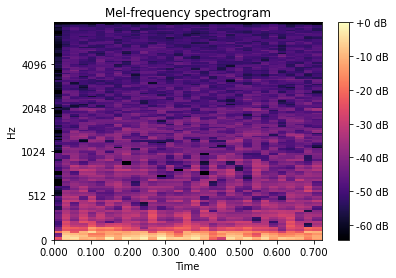

In [135]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(mel_train[0], ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

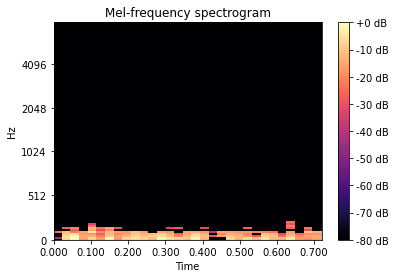

In [136]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(MEL_train[0], ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

# Кепстральные коэффициенты Mel-частоты (MFCC)

Делим коэффициенты на кадры

In [354]:
mfccs1_train = []
for i in range(len(frames_train[0])):   
    mfccs1_train.append(librosa.feature.mfcc(y=frames_train[:,i], sr=sr, hop_length=512, htk=True, n_mfcc=15,dct_type = 2,norm = None))

In [355]:
mfccs1_valid = []
for i in range(len(frames_valid[0])):   
    mfccs1_valid.append(librosa.feature.mfcc(y=frames_valid[:,i], sr=sr, hop_length=512, htk=True, n_mfcc=15,dct_type = 2,norm = None))

In [356]:
mfccs1_train=np.array(mfccs1_train)
mfccs1_valid=np.array(mfccs1_valid)

In [357]:
mfccs1_train.shape

(3281, 15, 46)

In [358]:
mfccs1_valid.shape

(2048, 15, 46)

Нормируем все коэффициенты

In [359]:
mfccs_train = []
scaler = preprocessing.StandardScaler()
for i in range(len(mfccs1_train)): 
    scaler.fit(mfccs1_train[i])
for i in range(len(mfccs1_train)): 
    mfccs_train.append(scaler.transform(mfccs1_train[i]))

In [360]:
mfccs_valid = []
scaler = preprocessing.StandardScaler()
for i in range(len(mfccs1_train)): 
    scaler.fit(mfccs1_train[i])
for i in range(len(mfccs1_valid)): 
    mfccs_valid.append(scaler.transform(mfccs1_valid[i]))

In [361]:
MFCCS_train = []
for i in range(len(frames_train[0])): 
    MFCCS_train.append(mfccs_train[i].flatten())
#    print(MFCCS_train[0])

In [362]:
MFCCS_valid = []
for i in range(len(frames_valid[0])): 
    MFCCS_valid.append(mfccs_valid[i].flatten())
#    print(MFCCS_valid[0])

In [363]:
MFCCS_train=np.array(MFCCS_train, dtype=float)
MFCCS_train.shape

(3281, 690)

In [364]:
len(block_train)

3281

In [365]:
MFCCS_valid=np.array(MFCCS_valid, dtype=float)
MFCCS_valid.shape

(2048, 690)

# Оконное преобразование Фурье (STFT).

In [376]:
window=('kaiser', 4.0)

In [377]:
stft1_train = []
for i in range(len(frames_train[0])):   
    stft1_train.append(librosa.stft(y=frames_train[:,i], n_fft = 512, hop_length = 500, win_length = None, window = window, center = True, dtype = None, pad_mode = 'reflect'))

In [378]:
stft1_valid = []
for i in range(len(frames_valid[0])):   
    stft1_valid.append(librosa.stft(y=frames_valid[:,i], n_fft = 512, hop_length = 500, win_length = None, window = window, center = True, dtype = None, pad_mode = 'reflect'))

boxcar
triang
blackman
hamming
hann
bartlett
flattop
parzen
bohman
blackmanharris
nuttall
barthann
cosine
exponential
tukey
taylor
kaiser (нужна бета)
gaussian (требуется стандартное отклонение)
general_cosine (требуются весовые коэффициенты)
general_gaussian (требуется мощность, ширина)
general_hamming (требуется оконный коэффициент)
dpss (требуется нормализованная половина полосы пропускания)
chebwin (требуется затухание)
(В некоторых источниках используется альфа = бета / пи.

In [379]:
stft2_train = []
for i in range(len(frames_train[0])): 
    stft2_train.append(stft1_train[i].astype(np.float32))

<ipython-input-379-e6ef4f64bd54>:3: ComplexWarning: Casting complex values to real discards the imaginary part
  stft2_train.append(stft1_train[i].astype(np.float32))


In [380]:
stft2_valid = []
for i in range(len(frames_valid[0])): 
    stft2_valid.append(stft1_valid[i].astype(np.float32))

<ipython-input-380-bebbfaaa7884>:3: ComplexWarning: Casting complex values to real discards the imaginary part
  stft2_valid.append(stft1_valid[i].astype(np.float32))


In [381]:
stft_train = []
scaler = preprocessing.StandardScaler()
for i in range(len(stft2_train)): 
    scaler.fit(stft2_train[i])
for i in range(len(stft2_train)): 
    stft_train.append(scaler.transform(stft2_train[i]))

In [382]:
stft_valid = []
scaler = preprocessing.StandardScaler()
for i in range(len(stft2_train)): 
    scaler.fit(stft2_train[i])
for i in range(len(stft2_valid)): 
    stft_valid.append(scaler.transform(stft2_valid[i]))

D:\Alexandra\Anaconda\lib\site-packages\librosa\core\spectrum.py:1641: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn(


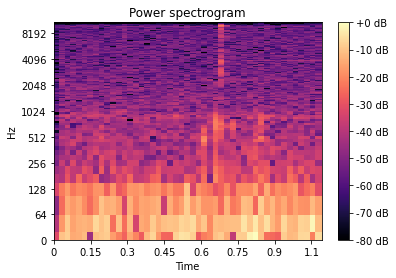

In [383]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(stft1_train[0],
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

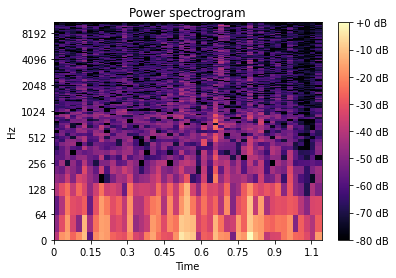

In [384]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(stft_train[0],
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [385]:
STFT_train = []
for i in range(len(frames_train[0])): 
    STFT_train.append(stft_train[i].flatten())

In [386]:
STFT_valid = []
for i in range(len(frames_valid[0])): 
    STFT_valid.append(stft_valid[i].flatten())

In [387]:
STFT_train=np.array(STFT_train, dtype=float)
#print(STFT_train[0])
STFT_train.shape

(3281, 12079)

In [388]:
STFT_valid=np.array(STFT_valid, dtype=float)
#print(STFT_valid[0])
STFT_valid.shape

(2048, 12079)

In [389]:
#x_df = STFT
#y_df = block

# Вейвлет-преобразование 

In [410]:
import pywt

In [411]:
#Возвращает список доступных встроенных семейств вейвлетов.
#Хаар ( haar )
#Добеши ( db )
#Symlets ( sym )
#Койфлеты ( coif )
#Биортогональный ( bior )
#Обратный биортогональный ( rbio )
#«Дискретное» FIR-приближение вейвлета Мейера ( dmey )
pywt.families()

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

In [412]:
print(pywt.wavelist( 'dmey'))

['dmey']


In [413]:
wavelet = pywt.Wavelet('dmey')
print(wavelet)

Wavelet dmey
  Family name:    Discrete Meyer (FIR Approximation)
  Short name:     dmey
  Filters length: 62
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       symmetric
  DWT:            True
  CWT:            False


In [414]:
waveletcad_train = []
for i in range(len(frames_train[0])):  
    cad  = pywt.dwt(frames_train[:,i], wavelet , mode='symmetric', axis=-1)
    waveletcad_train.append(cad)

In [415]:
waveletcad_valid = []
for i in range(len(frames_valid[0])):  
    cad  = pywt.dwt(frames_valid[:,i], wavelet , mode='symmetric', axis=-1)
    waveletcad_valid.append(cad)

In [416]:
#wavelet.filter_bank
#(w.dec_lo, w.dec_hi, w.rec_lo, w.rec_hi) 

In [417]:
waveletcAD_train = []
scaler = preprocessing.StandardScaler()
for i in range(len(waveletcad_train)): 
    scaler.fit(waveletcad_train[i])
for i in range(len(waveletcad_train)): 
    waveletcAD_train.append(scaler.transform(waveletcad_train[i]))

In [418]:
waveletcAD_valid = []
scaler = preprocessing.StandardScaler()
for i in range(len(waveletcad_train)): 
    scaler.fit(waveletcad_train[i])
for i in range(len(waveletcad_valid)): 
    waveletcAD_valid.append(scaler.transform(waveletcad_valid[i]))

In [419]:
waveletcAD_train=np.array(waveletcAD_train, dtype=float)
#print(waveletCA_train[0])
waveletcAD_train.shape

(3281, 2, 11747)

In [420]:
waveletcAD_valid=np.array(waveletcAD_valid, dtype=float)
#print(waveletCA_valid[0])
waveletcAD_valid.shape

(2048, 2, 11747)

In [74]:
#x_df = waveletcAD_train
#y_df = block_train

# Делим на обучающую и тестовую выборки и обучаем

In [75]:
#x_df = MEL2_train

In [76]:
#y_df = block_train

In [500]:
x_train = STFT_train
y_train = block_train

In [501]:
x_valid = STFT_valid
y_valid = block_valid

In [289]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [237]:
#x_train, x_valid, y_train, y_valid = train_test_split(x_df,y_df, test_size=0.3, random_state=17)

In [238]:
np.count_nonzero(y_valid == 1)

290

In [239]:
np.count_nonzero(y_valid == 0)

1806

In [240]:
 np.count_nonzero(y_train == 1)

845

In [241]:
np.count_nonzero(y_train == 0)

6741

# Нейронная сеть

In [45]:
import tensorflow as tf
from tensorflow import keras
from  tensorflow.keras import layers

In [502]:
r=len(x_train)
u=len(x_train[0])
print(u,r)

12079 3281


In [503]:
model = tf.keras.Sequential([                                       #Sequential группирует линейную стопку слоев в tf.keras.Model.
    tf.keras.layers.Flatten(input_shape=(u,)),                      #преобразует матрицу ввода в единый массив.
#   tf.keras.layers.Dense(128, kernel_initializer='orthogonal'),    #генерирует случайные веса
    tf.keras.layers.Dense(128, activation=tf.nn.relu),              #Применяет функцию активации выпрямленного линейного блока.   
#Схемы регуляризации добавляемые к весам слоя (ядро и сдвиг), такие как L1 или L2 регуляризации.
#kernel_regularizer : функция регуляризатора, применяемая к матрице весов ядра.
#bias_regularizer : функция регуляризатора, применяемая к вектору смещения.
    tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dense(64, bias_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax),   #2 категории 0 и 1; преобразует вектор значений в распределение вероятностей
])

In [504]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [505]:
history = model.fit(x_train, y_train, epochs=5)

Epoch 1/5
103/103 [==============================] - 1s 11ms/step - loss: 10.2974 - accuracy: 0.7543
Epoch 2/5
103/103 [==============================] - 1s 11ms/step - loss: 4.6327 - accuracy: 0.8683
Epoch 3/5
103/103 [==============================] - 1s 11ms/step - loss: 1.4296 - accuracy: 0.9122
Epoch 4/5
103/103 [==============================] - 1s 13ms/step - loss: 0.5413 - accuracy: 0.9323
Epoch 5/5
103/103 [==============================] - 1s 11ms/step - loss: 0.3507 - accuracy: 0.9555


In [506]:
test_loss, test_acc = model.evaluate(x_valid, y_valid)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

64/64 [==============================] - 0s 4ms/step - loss: 1.0094 - accuracy: 0.7334
Test accuracy: 0.7333984375
Test loss: 1.0093709230422974


In [507]:
predictions = model.predict(x_valid)

In [508]:
from sklearn.metrics import classification_report
print(classification_report(y_valid,predictions.argmax(axis=1)))
print(classification_report(y_valid,np.zeros(y_valid.shape[0])))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1600
           1       0.38      0.36      0.37       448

    accuracy                           0.73      2048
   macro avg       0.60      0.60      0.60      2048
weighted avg       0.73      0.73      0.73      2048

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      1600
           1       0.00      0.00      0.00       448

    accuracy                           0.78      2048
   macro avg       0.39      0.50      0.44      2048
weighted avg       0.61      0.78      0.69      2048



# Сверточная нейронная сеть

In [509]:
x_cnn_train = stft_train
y_cnn_train = block_train

In [510]:
x_cnn_valid = stft_valid
y_cnn_valid = block_valid

In [511]:
x_cnn_train=np.array(x_cnn_train)
x_cnn_valid=np.array(x_cnn_valid)

In [512]:
#x_cnn_df = mfccs_train
#y_cnn_df = block_train

In [513]:
#x_cnn_train, x_cnn_valid, y_cnn_train, y_cnn_valid = train_test_split(x_cnn_df,y_cnn_df, test_size=0.3, random_state=17)

In [514]:
#x_cnn_train=np.array(x_cnn_train)
#x_cnn_valid=np.array(x_cnn_valid)

In [515]:
model = tf.keras.Sequential([    
    tf.keras.layers.Conv1D(64, kernel_size = 3, activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size = 3, activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(input_shape=()),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)   
])

In [516]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [517]:
model.fit(x_cnn_train, y_cnn_train, epochs=5)

Epoch 1/5
103/103 [==============================] - 2s 14ms/step - loss: 0.5117 - accuracy: 0.7876
Epoch 2/5
103/103 [==============================] - 1s 14ms/step - loss: 0.3325 - accuracy: 0.8500
Epoch 3/5
103/103 [==============================] - 2s 15ms/step - loss: 0.2631 - accuracy: 0.8903
Epoch 4/5
103/103 [==============================] - 1s 14ms/step - loss: 0.2007 - accuracy: 0.9168
Epoch 5/5
103/103 [==============================] - 1s 13ms/step - loss: 0.1383 - accuracy: 0.9506


In [518]:
test_loss, test_acc = model.evaluate(x_cnn_valid, y_cnn_valid)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

64/64 [==============================] - 0s 4ms/step - loss: 0.9607 - accuracy: 0.6440
Test accuracy: 0.64404296875
Test loss: 0.9607346653938293


In [519]:
predictions = model.predict(x_cnn_valid)

In [520]:
print(classification_report(y_valid,predictions.argmax(axis=1)))
print(classification_report(y_valid,np.zeros(y_valid.shape[0])))

              precision    recall  f1-score   support

           0       0.80      0.73      0.76      1600
           1       0.26      0.35      0.30       448

    accuracy                           0.64      2048
   macro avg       0.53      0.54      0.53      2048
weighted avg       0.68      0.64      0.66      2048

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      1600
           1       0.00      0.00      0.00       448

    accuracy                           0.78      2048
   macro avg       0.39      0.50      0.44      2048
weighted avg       0.61      0.78      0.69      2048



Вейвлет

In [464]:
x_cnn_train = waveletcAD_train
y_cnn_train = block_train

In [465]:
x_cnn_valid = waveletcAD_valid
y_cnn_valid = block_valid

In [466]:
model2 = tf.keras.Sequential([    
    tf.keras.layers.Conv1D(128, kernel_size = 1, activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=1,padding='same'),
    tf.keras.layers.Conv1D(128, kernel_size = 1, activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=1,padding='same'),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax),   
    tf.keras.layers.Flatten(input_shape=())
    ])

In [467]:
model2.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [468]:
model2.fit(x_cnn_train, y_cnn_train, epochs=5)

Epoch 1/5
103/103 [==============================] - 6s 32ms/step - loss: 3.9363 - accuracy: 0.7976
Epoch 2/5
103/103 [==============================] - 3s 29ms/step - loss: 3.8863 - accuracy: 0.8019
Epoch 3/5
103/103 [==============================] - 3s 29ms/step - loss: 3.8861 - accuracy: 0.8019 1s - loss: 3.8912 - accuracy: 0.80 - ETA
Epoch 4/5
103/103 [==============================] - 3s 29ms/step - loss: 3.8814 - accuracy: 0.8022
Epoch 5/5
103/103 [==============================] - 3s 30ms/step - loss: 3.8814 - accuracy: 0.8022


In [469]:
test_loss, test_acc = model2.evaluate(x_cnn_valid, y_cnn_valid)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

64/64 [==============================] - 0s 4ms/step - loss: 4.2190 - accuracy: 0.7812
Test accuracy: 0.78125
Test loss: 4.218980312347412


In [470]:
predictions = model2.predict(x_cnn_valid)

In [471]:
print(classification_report(y_valid,predictions.argmax(axis=1)))
print(classification_report(y_valid,np.zeros(y_valid.shape[0])))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      1600
           1       0.00      0.00      0.00       448

    accuracy                           0.78      2048
   macro avg       0.39      0.50      0.44      2048
weighted avg       0.61      0.78      0.69      2048

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      1600
           1       0.00      0.00      0.00       448

    accuracy                           0.78      2048
   macro avg       0.39      0.50      0.44      2048
weighted avg       0.61      0.78      0.69      2048



# Дерево решений

Обучаем модель

In [521]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
tree.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=17)

Оценка модели

In [522]:
tree_pred = tree.predict(x_valid)
accuracy_score(y_valid, tree_pred) 

0.7001953125

ROC-кривая (англ. receiver operating characteristic, рабочая характеристика приёмника) — график, позволяющий оценить
качество бинарной классификации, отображает соотношение между долей объектов от общего количества носителей признака,
верно классифицированных как несущие признак (англ. true positive rate, TPR, называемой чувствительностью алгоритма
классификации), и долей объектов от общего количества объектов, не несущих признака, ошибочно классифицированных
как несущие признак (англ. false positive rate, FPR, величина 1-FPR называется специфичностью алгоритма классификации) 
при варьировании порога решающего правила.

Также известна как кривая ошибок. Анализ классификаций с применением ROC-кривых называется ROC-анализом.

Количественная интерпретация ROC даёт показатель AUC (англ. Area Under Curve, площадь под кривой) — площадь, ограниченная
ROC-кривой и осью доли ложных положительных классификаций. Чем выше показатель AUC, тем качественнее классификатор, 
при этом значение 0,5 демонстрирует непригодность выбранного метода классификации (соответствует случайному гаданию).
Значение менее 0,5 говорит, что классификатор действует с точностью до наоборот: если положительные назвать отрицательными
и наоборот, классификатор будет работать лучше.

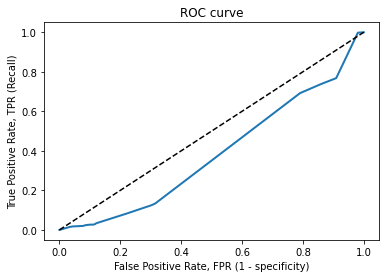

In [523]:
fpr, tpr, thresholds = roc_curve(y_valid, tree.predict_proba(x_valid)[:,1], pos_label=1)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

Precision можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно 
являющимися положительными, а recall показывает, какую долю объектов положительного класса из всех объектов положительного
класса нашел алгоритм. Precision и recall не зависят, в отличие от accuracy, от соотношения классов и потому применимы 
в условиях несбалансированных выборок.

F-мера достигает максимума при максимальной полноте и точности, и близка к нулю, если один из аргументов близок к нулю. 
F-мера является хорошим кандидатом на формальную метрику оценки качества классификатора. 
Она сводит к одному числу две других основополагающих метрики: точность и полноту. 
Имея "F-меру" гораздо проще ответить на вопрос: "поменялся алгоритм в лучшую сторону или нет?"

In [524]:
report = classification_report(y_valid, tree.predict(x_valid), target_names=['0', '1'])
print(report)

              precision    recall  f1-score   support

           0       0.77      0.89      0.82      1600
           1       0.06      0.03      0.04       448

    accuracy                           0.70      2048
   macro avg       0.41      0.46      0.43      2048
weighted avg       0.61      0.70      0.65      2048



# Настроим параметры модели

In [525]:
tree_params = {'max_depth': range(1,11),'max_features': range(1,19)}

In [526]:
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

In [527]:
tree_grid.fit(x_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  3.1min finished


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(1, 19)},
             verbose=True)

In [528]:
tree_grid.best_score_,tree_grid.best_params_

(0.8021944722871887, {'max_depth': 1, 'max_features': 1})

In [529]:
accuracy_score(y_valid, tree_grid.predict(x_valid))

0.78125

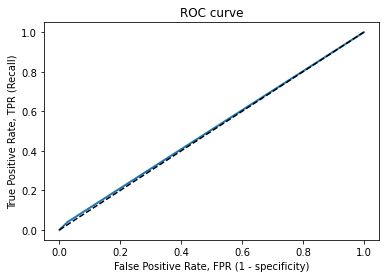

In [530]:
fpr, tpr, thresholds = roc_curve(y_valid, tree_grid.predict_proba(x_valid)[:,1], pos_label=1)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

In [531]:
report = classification_report(y_valid, tree_grid.predict(x_valid), target_names=['0', '1'])
print(report)

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      1600
           1       0.00      0.00      0.00       448

    accuracy                           0.78      2048
   macro avg       0.39      0.50      0.44      2048
weighted avg       0.61      0.78      0.69      2048



D:\Alexandra\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Метод ближайших соседей

Обучаем модель

In [532]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

Оценка модели

In [533]:
knn_pred = knn.predict(x_valid)
accuracy_score(y_valid, knn_pred) 

0.71240234375

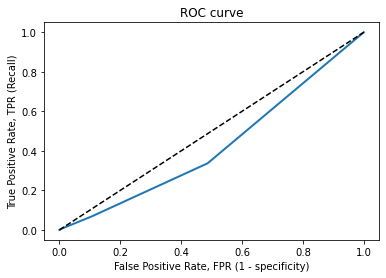

In [534]:
fpr, tpr, thresholds = roc_curve(y_valid, knn.predict_proba(x_valid)[:,1], pos_label=1)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

In [535]:
report = classification_report(y_valid, knn.predict(x_valid), target_names=['0', '1'])
print(report)

              precision    recall  f1-score   support

           0       0.77      0.89      0.83      1600
           1       0.15      0.07      0.10       448

    accuracy                           0.71      2048
   macro avg       0.46      0.48      0.46      2048
weighted avg       0.64      0.71      0.67      2048



Настроим параметры модели

In [536]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

In [537]:
knn_params = {'knn__n_neighbors': range(1, 10)}

In [538]:
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True)

In [539]:
knn_grid.fit(x_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 11.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-1))]),
             n_jobs=-1, param_grid={'knn__n_neighbors': range(1, 10)},
             verbose=True)

In [540]:
knn_grid.best_params_, knn_grid.best_score_

({'knn__n_neighbors': 2}, 0.6236547314103278)

In [541]:
accuracy_score(y_valid, knn_grid.predict(x_valid))

0.58984375

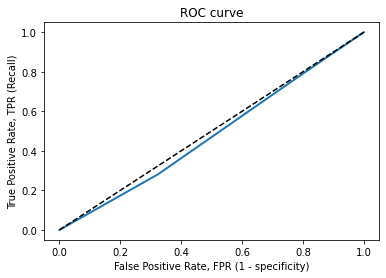

In [542]:
fpr, tpr, thresholds = roc_curve(y_valid, knn_grid.predict_proba(x_valid)[:,1], pos_label=1)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

In [543]:
report = classification_report(y_valid, knn_grid.predict(x_valid), target_names=['0', '1'])
print(report)

              precision    recall  f1-score   support

           0       0.77      0.68      0.72      1600
           1       0.20      0.28      0.23       448

    accuracy                           0.59      2048
   macro avg       0.48      0.48      0.48      2048
weighted avg       0.64      0.59      0.61      2048



# Случайный лес

In [ ]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
print(np.mean(cross_val_score(forest, x_train, y_train, cv=5))) 

In [ ]:
forest_params = {'max_depth': range(1,11), 'max_features': range(1,19)}

In [ ]:
forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1, verbose=True)

In [ ]:
forest_grid.fit(x_train, y_train)

In [ ]:
forest_grid.best_params_, forest_grid.best_score_ 

In [ ]:
accuracy_score(y_valid, forest_grid.predict(x_valid))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_valid, forest_grid.predict_proba(x_valid)[:,1], pos_label=1)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
report = classification_report(y_valid, forest_grid.predict(x_valid), target_names=['0', '1'])
print(report)

# Логистическая регрессия 

In [199]:
model = LogisticRegression(solver='liblinear', random_state=0)

In [200]:
model.fit(x_train, y_train)

D:\Alexandra\Anaconda\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LogisticRegression(random_state=0, solver='liblinear')

In [201]:
#LogisticRegression(
#    C=1.0, 
#    class_weight=None, 
#    dual=False, 
#    fit_intercept=True,
#    intercept_scaling=1, 
#    l1_ratio=None, 
#    max_iter=100,
#    multi_class='warn', 
#    n_jobs=None, 
#    penalty='l2',
#    random_state=0, 
#    solver='liblinear', 
#    tol=0.0001, 
#    verbose=0,
#    warm_start=False
#)

In [202]:
model = LogisticRegression(solver='liblinear', random_state=0).fit(x_train, y_train)

D:\Alexandra\Anaconda\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [203]:
#Это пример двоичной классификации, и y может быть 0 или 1
model.classes_

array([0, 1])

In [204]:
#Можно получить значение наклона b1 и точку пересечения b0 линейной функции f следующим образом
#b0 задается внутри одномерного массива, а b1 — внутри двумерного массива
model.intercept_
model.coef_

array([[-0.00112907, -0.00176132,  0.0002297 , ...,  0.00120857,
         0.00174714,  0.00149023]])

In [205]:
#Первый столбец — это вероятность того, что прогнозируемый результат будет равен нулю, то есть 1−p(x).
#Второй столбец — это вероятность того, что на выходе будет единица или p(x).
model.predict_proba(x_valid)

array([[9.93534262e-01, 6.46573798e-03],
       [9.99261008e-01, 7.38992496e-04],
       [9.85571284e-01, 1.44287158e-02],
       ...,
       [9.96771026e-01, 3.22897448e-03],
       [8.86162190e-01, 1.13837810e-01],
       [8.91665768e-01, 1.08334232e-01]])

In [206]:
#Фактические прогнозы
model.predict(x_valid)

array([0, 0, 0, ..., 0, 0, 0])

In [207]:
model.score(x_valid, y_valid)

0.808206106870229

In [208]:
#Чтобы создать матрицу ошибок, вы можете использовать confusion_matrix() и предоставить
#фактические и прогнозируемые результаты в качестве аргументов:
confusion_matrix(y_valid, model.predict(x_valid))

array([[1655,  151],
       [ 251,   39]], dtype=int64)

In [ ]:
cm = confusion_matrix(y_valid, model.predict(x_valid))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(y_valid, model.predict_proba(x_valid)[:,1], pos_label=1)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

In [209]:
report = classification_report(y_valid, model.predict(x_valid), target_names=['0', '1'])
print(report)

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1806
           1       0.21      0.13      0.16       290

    accuracy                           0.81      2096
   macro avg       0.54      0.53      0.53      2096
weighted avg       0.78      0.81      0.79      2096



In [210]:
print(classification_report(y_valid, model.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1806
           1       0.21      0.13      0.16       290

    accuracy                           0.81      2096
   macro avg       0.54      0.53      0.53      2096
weighted avg       0.78      0.81      0.79      2096



# Улучшенная модель логистической регрессии Попытка провалилась (C=10.0)

In [ ]:
model = LogisticRegression(solver='liblinear', C=10.0, random_state=0)
model.fit(x_train, y_train)

In [ ]:
model.intercept_,model.coef_

In [ ]:
model.predict_proba(x_valid)

In [ ]:
model.predict(x_valid)

In [ ]:
model.score(x_valid, y_valid)

In [ ]:
confusion_matrix(y_valid, model.predict(x_valid))

In [ ]:
fpr, tpr, thresholds = roc_curve(y_valid, model.predict_proba(x_valid)[:,1], pos_label=1)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
print(classification_report(y_valid, model.predict(x_valid)))

# Стохастический градиентный спуск (Stochastic Gradient Descent SGD)

In [ ]:
sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(x_valid, y_valid) 
y_train_pred = cross_val_predict(sgd_clf, x_valid, y_valid, cv=3)

In [ ]:
accuracy_score(y_valid, y_train_pred)

In [ ]:
np.mean(cross_val_score(sgd_clf, x_train, y_train, cv=3))

In [ ]:
y_scores = cross_val_predict(sgd_clf, x_valid, y_valid, cv=3, method="decision_function")
fpr, tpr, thresholds = roc_curve(y_valid, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
print(classification_report(y_valid, sgd_clf.predict(x_valid)))

# Визуализация дерева решений

In [ ]:
dot_data = tree.export_graphviz(tree_grid.best_estimator_, out_file='tree.dot',filled=True)

In [ ]:
!dir *png

In [ ]:
!dot -Tpng tree.dot -o tree.png

In [ ]:
Image(filename='tree.png') 

# Построение кривых валидации для kNN

In [ ]:
train_scores, valid_scores = [], []
n_neighb = [1, 2, 3, 5, 6, 7] + list(range(50, 500, 50))

for k in n_neighb:
    knn = KNeighborsClassifier(n_neighbors=k)
    train_scores.append(np.mean(cross_val_score(knn, x_train, y_train, cv=5)))
    knn.fit(x_train, y_train)
    valid_scores.append(accuracy_score(y_valid, knn.predict(x_valid)))  

plt.plot(n_neighb, train_scores, label='train')
plt.plot(n_neighb, valid_scores, label='valid')
plt.title('kNN')
plt.legend();

In [ ]:
mel_basis = librosa.filters.mel(sr=22050, n_fft=512, n_mels=10,fmin=0, fmax=sr / 2)

In [ ]:
plt.subplot(2,1,1)
plt.pcolormesh(mel_basis)
plt.colorbar()

In [ ]:
sr = 22050
mel_basis = librosa.filters.mel(sr=sr, n_fft=512, n_mels=10,fmin=0, fmax=sr / 2, htk=False, norm=None)

In [ ]:
plt.plot(mel_basis.T)
plt.show()